In [75]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn

from collections import defaultdict
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [76]:
path = "./seattle/"
df = pd.read_csv(path+"listings.csv")
calender = pd.read_csv(path+"calendar.csv")
review = pd.read_csv(path+"reviews.csv")

In [96]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month,days,week,host_since_y,host_since_m,host_since_d
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3163.000000,3162.000000,0.0,3818.000000,3191.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,9.608916,9.452245,NaN,2.946307,2.078919,2.634696,26.816038,2013.214623,6.551887,15.545073
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,0.629053,0.750259,NaN,5.893029,1.822348,2.013244,13.972345,1.560423,3.208349,8.994628
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,4.000000,2.000000,NaN,1.000000,0.020000,0.000000,1.000000,2008.000000,1.000000,1.000000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,9.000000,9.000000,NaN,1.000000,0.695000,1.000000,15.000000,2012.000000,4.000000,8.000000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,10.000000,10.000000,NaN,1.000000,1.540000,2.000000,28.000000,2013.000000,7.000000,15.000000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,10.000000,10.000000,NaN,2.000000,3.000000,4.000000,38.000000,2015.000000,9.000000,24.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,10.000000,10.000000,NaN,37.000000,12.150000,6.000000,53.000000,2016.000000,12.000000,31.000000


In [78]:
calender.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [79]:
def convertDate(dataframe, col):
    
    suffixes = ['y','m','d']
    date = pd.to_datetime(dataframe[col])
    dataframe['days'] = date.dt.dayofweek
    dataframe['week'] = date.dt.week
    split_df = dataframe[col].str.split('-',expand=True).rename(columns ={idx:'%s_%s' % (col, suffix) for idx, suffix in enumerate (suffixes)}).applymap(float)
    dataframe = pd.concat((dataframe.drop([col],axis=1),split_df),axis=1)
    
    return dataframe

In [80]:
def cleanPrice(dataframe,col):
    
    removeCurrency = lambda x:float(x.lstrip('$').replace(",",""))
    dataframe[col] = dataframe[col].apply(removeCurrency)
    
    return dataframe

In [81]:
def convertLower(dataframe):
    dataframe = dataframe.applymap(lambda x: str.lower(x) if isinstance(x,str) else x)
    return dataframe

In [82]:
calender.dropna(inplace = True)
calender = convertLower(calender)
calender = cleanPrice(calender,"price")
calender = convertDate(calender , 'date')

calender.head()

,listing_id,available,price,days,week,date_y,date_m,date_d
0,241032,t,85.0,0,1,2016.0,1.0,4.0
1,241032,t,85.0,1,1,2016.0,1.0,5.0
9,241032,t,85.0,2,2,2016.0,1.0,13.0
10,241032,t,85.0,3,2,2016.0,1.0,14.0
14,241032,t,85.0,0,3,2016.0,1.0,18.0


In [83]:
df = convertDate(df,'host_since')
df = convertLower(df)
df = cleanPrice(df,'price')

df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days,week,host_since_y,host_since_m,host_since_d
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,stylish queen anne apartment,NaN,make your self at home in this charming one-be...,make your self at home in this charming one-be...,none,NaN,...,moderate,f,f,2,4.07,3.0,32.0,2011.0,8.0,11.0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,bright & airy queen anne apartment,chemically sensitive? we've removed the irrita...,"beautiful, hypoallergenic apartment in an extr...",chemically sensitive? we've removed the irrita...,none,"queen anne is a wonderful, truly functional vi...",...,strict,t,t,6,1.48,3.0,8.0,2013.0,2.0,21.0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,new modern house-amazing water view,new modern house built in 2013. spectacular s...,"our house is modern, light and fresh with a wa...",new modern house built in 2013. spectacular s...,none,upper queen anne is a charming neighborhood fu...,...,strict,f,f,2,1.15,3.0,24.0,2014.0,6.0,12.0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,queen anne chateau,a charming apartment that sits atop queen anne...,NaN,a charming apartment that sits atop queen anne...,none,NaN,...,flexible,f,f,1,NaN,2.0,45.0,2013.0,11.0,6.0
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,charming craftsman 3 bdm house,cozy family craftman house in beautiful neighb...,cozy family craftman house in beautiful neighb...,cozy family craftman house in beautiful neighb...,none,we are in the beautiful neighborhood of queen ...,...,strict,f,f,1,0.89,1.0,48.0,2011.0,11.0,29.0


## Neighboorhd and Municipalty

In [84]:

city_info = df.groupby('city')['price']
city_info.mean()

city
ballard, seattle         116.000000
phinney ridge seattle     60.000000
seattle                  128.046182
seattle                   97.500000
west seattle             110.000000
西雅图                       38.000000
Name: price, dtype: float64

In [85]:
df[[x for x in df.columns if 'neighb' in x]]

,neighborhood_overview,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,NaN,queen anne,queen anne,west queen anne,queen anne
1,"queen anne is a wonderful, truly functional vi...",queen anne,queen anne,west queen anne,queen anne
2,upper queen anne is a charming neighborhood fu...,queen anne,queen anne,west queen anne,queen anne
3,NaN,queen anne,queen anne,west queen anne,queen anne
4,we are in the beautiful neighborhood of queen ...,queen anne,queen anne,west queen anne,queen anne
5,this part of queen anne has wonderful views an...,queen anne,queen anne,west queen anne,queen anne
6,"close restaurants, coffee shops and grocery st...",queen anne,queen anne,west queen anne,queen anne
7,we are centrally located between downtown and ...,queen anne,queen anne,west queen anne,queen anne
8,walking score: 92 4 blocks from kerry park fam...,queen anne,queen anne,west queen anne,queen anne
9,"queen anne is a wonderful, truly functional vi...",queen anne,queen anne,west queen anne,queen anne


(0, 400)

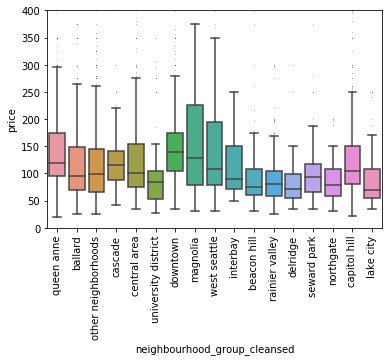

In [94]:
ax = seaborn.boxplot(data=df,x='neighbourhood_group_cleansed',y='price',fliersize=0.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(0,400)